# 1. 모델 YOLOV5 다운로드

In [1]:
%cd /content
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt # install dependencies

import torch
from IPython.display import Image, clear_output
# display=utils.notebook_init()

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 11854, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 11854 (delta 22), reused 31 (delta 21), pack-reused 11820
Receiving objects: 100% (11854/11854), 11.37 MiB | 24.25 MiB/s, done.
Resolving deltas: 100% (8209/8209), done.
/content/yolov5
     |████████████████████████████████| 596 kB 9.9 MB/s 


# 2. 추론(Inference)

### detect.py- yolov5 모델을 이용한 추론

### 주어진 이미지를 바운딩 박스 작업(detect)

In [18]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/

detect: weights=['yolov5s.pt'], source=data/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-62-ga0a4adf torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, Done. (0.032s)
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, Done. (0.028s)
Speed: 0.5ms pre-process, 30.0ms inference, 1.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


# 3. 포트홀 탐지 모델

### 포트홀 데이터셋 다운로드(roboflow)

포트홀 데이터셋: https://public.roboflow.com/object-detection/pothole

## 포트홀 데이터셋을 설치한다.

In [2]:
%mkdir /content/pothole
%cd /content/pothole
!curl -L "https://public.roboflow.com/ds/m0E5Tx4om4?key=kEKT9jhfJu" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content/pothole
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1739      0 --:--:-- --:--:-- --:--:--  1739
100 46.0M  100 46.0M    0     0  19.9M      0  0:00:02  0:00:02 --:--:-- 28.9M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg  
 extracting: test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg  
 extracting: test/images/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg  
 extracting: test/images/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg  
 extracting: test/images/img-168_jpg.rf.af3590e07b06b43e91fa53990ff94af3.jpg  
 extracting: test/images/img-179_jpg.rf.8632eb0d9b75fefe144829e67b75015a.jpg  
 extracting

## list를 정리(train, test, valid의 이미지 갯수 확인)

In [3]:
from glob import glob

train_img_list=glob('/content/pothole/train/images/*.jpg')
test_img_list=glob('/content/pothole/test/images/*.jpg')
valid_img_list=glob('/content/pothole/valid/images/*.jpg')
print(len(train_img_list),len(test_img_list), len(valid_img_list))

465 67 133


## txt화일로 저장

In [4]:
import yaml

with open('/content/pothole/train.txt', 'w') as f:
  f.write('\n'.join(train_img_list) + '\n')
with open('/content/pothole/test.txt', 'w') as f:
  f.write('\n'.join(test_img_list) + '\n')  
with open('/content/pothole/val.txt', 'w') as f:
  f.write('\n'.join(valid_img_list) + '\n')

## 현재 data.yaml화일을 열어보자.

In [5]:
%cat /content/pothole/data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['pothole']

## yaml 의 내용을 수정할 수 있도록 writetemplate 명령을 사용할 수 있게 수정한다.

In [6]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
  with open(line, 'w') as f:
    f.write(cell.format(**globals()))

## 내용을 수정한다.

In [7]:
%%writetemplate /content/pothole/data.yaml

train: /content/pothole/train/images
test: /content/pothole/test/images
val: /content/pothole/valid/images

nc: 1
names: ['pothole']

## 원하는데로 저장이 되는지 확인한다.

In [8]:
%cat /content/pothole/data.yaml


train: /content/pothole/train/images
test: /content/pothole/test/images
val: /content/pothole/valid/images

nc: 1
names: ['pothole']

# 4. 학습하기

## - train.py 사용

In [9]:
%%time
%cd /content/yolov5
!python train.py --img 640 --batch 16 --epochs 10 --data /content/pothole/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name pothole_results --cache



/content/yolov5
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/content/pothole/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=pothole_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-62-ga0a4adf torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.0

In [29]:
!python detect.py --weights /content/yolov5/runs/train/pothole_results/weights/last.pt --img 640 --conf 0.25 --source /content/pothole/train/images

detect: weights=['/content/yolov5/runs/train/pothole_results/weights/last.pt'], source=/content/pothole/train/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-62-ga0a4adf torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/465 /content/pothole/train/images/img-100_jpg.rf.233751cac3399aa80b5e58a2afbb753a.jpg: 640x640 1 pothole, Done. (0.033s)
image 2/465 /content/pothole/train/images/img-101_jpg.rf.f213d98946c4f8858a5bf3200c89e39c.jpg: 640x640 2 potholes, Done. (0.033s)
image 3/465 /content/pothole/train/images/img-102_jpg.rf.16c56ff8f761aec963

## 실행할 때 마다, 랜덤으로 이미지 출력하기

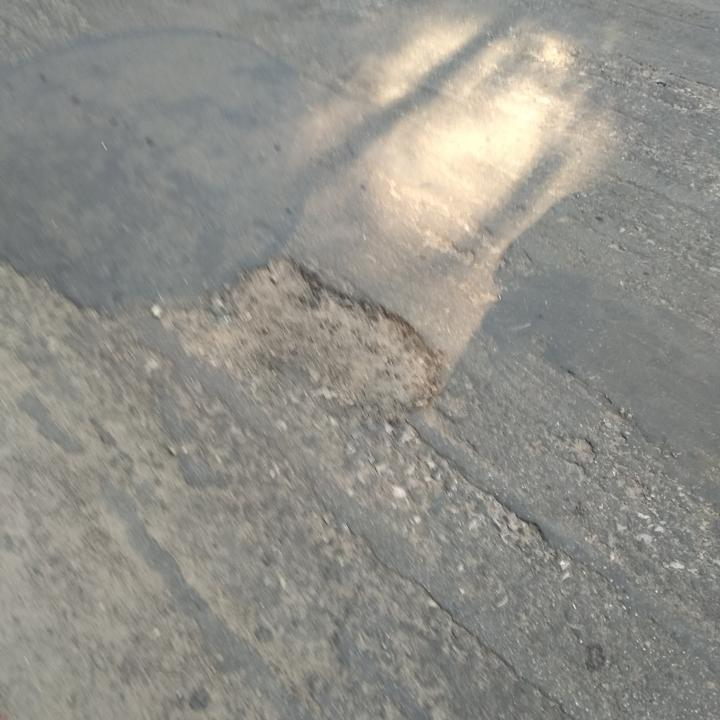

In [17]:
import glob
import random
from IPython.display import Image, display

Image_name = random.choice(glob.glob('/content/pothole/test/images/*.jpg'))
display(Image(filename=Image_name))

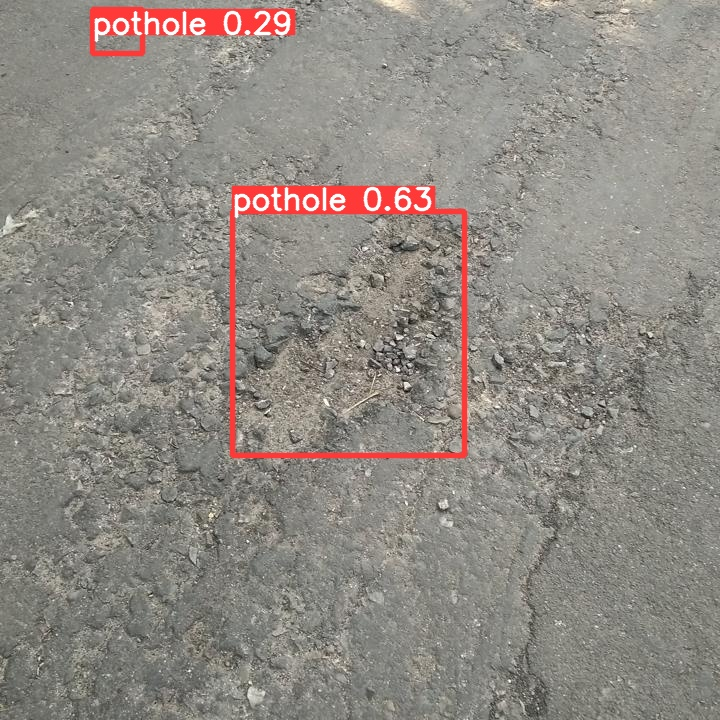

In [39]:
import glob
import random
from IPython.display import Image, display

Image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp4/*.jpg'))
display(Image(filename=Image_name))

# 5. 모델 출력
구글 코랩에서 드라이브를 불러온다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 구글 드라이브에 pothole 디렉토리를 만들고, best.pt 값을 copy한다.

In [ ]:
%mkdir /content/drive/MY\ Drive/pothole
%cp /content/yolov5/runs/train/pothole_results/weights/best.pt /content/drive/MY\ Drive/pothole/